## PART ONE: Using Sequence Profiles to Predict Whether a protein is broken or not

### What Are We Doing?

Today, we're going to use the power of **machine learning** to tackle a **real-world problem** — identifying dangerous types of bacteria! Specifically, we're looking at Salmonella, a type of bacteria that can cause illnesses. Some strains of Salmonella are more harmful than others, and we want to find out which ones are likely to cause severe diseases like bloodstream infections, instead of just food poisoning.

### Why Is It Important?

Understanding which variants of Salmonella are invasive can help doctors and scientists prevent serious illnesses. By predicting the behavior of these bacteria, we can help keep people safe from more dangerous infections.

### What is Machine Learning?

Machine learning is a way of teaching computers to learn from data. Instead of explicitly programming a computer every step of the way, we let it learn from examples. It's like how you might learn to recognize the difference between cats and dogs by looking at lots of pictures of each. Here, the computer learns to recognize patterns in data that we humans might not easily see.

### The Role of Broken Proteins

In our project, we are focusing on "broken proteins." Proteins are molecules that do a lot of important jobs in living things, including bacteria. Sometimes, in more invasive strains of Salmonella, certain proteins break or change. These changes can make the bacteria more dangerous. We are going to use data about these proteins to teach our computer model to predict if a strain of Salmonella is invasive.

In [1]:
# load libraries

import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns

import httpimport

with httpimport.github_repo('nwheeler443', 'AI_in_Schools_DNA', ref='master'):
    from utils.sequence_alignment_viewer import *
    from utils.utils import *
!pip install logomaker

import logomaker

from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


Fontconfig warning: ignoring UTF-8: not a valid region tag


## Discovering Patterns in Protein Sequences

Welcome to the detective part of our adventure! Just like detectives look for clues at a crime scene, we'll be looking for clues in protein sequences to predict how they function. Today, we'll start by learning how to read protein sequence alignments and use this information to calculate **match scores** for each sequence.

### Refresher: What is a Protein Sequence Alignment?

Imagine you have several strings of colorful beads. Each string represents a protein from different organisms but with a similar function. By lining up these strings side by side, you can see which beads (or amino acids, which are the building blocks of proteins) are in the same position across different strings. This lineup is what scientists call a **protein sequence alignment**.

### Why Do We Align Protein Sequences?

Aligning protein sequences helps us understand what's common between different proteins and which parts are crucial for their function. It’s like figuring out which parts of a car are needed to make it run properly by comparing different models.

Let's get started! First, we need to load an alignment of protein sequences, similar to our in-class lessons. 

In [2]:
# read in FASTA file of aligned protein sequences using Biopython

protein_sequence_dictionary = {}

# URL of the file you want to download
url = "https://raw.githubusercontent.com/nwheeler443/AI_in_Schools_DNA/main/Data/protein_sequences.csv"

protein_sequences = pd.read_csv(url, index_col=0)

# define the colours of our 'beads' - the different amino acids in a protein

clrs =  {'A':'red','L':'red','I':'red','V':'red','M':'red','F':'red','Y':'red','W':'red', # hydrophobic
                 'H':'blue','K':'blue','R':'blue', # basic
                 'D':'green','E':'green', # acidic
                 'S':'orange','T':'orange','N':'orange','Q':'orange', # polar
                 'C':'pink','U':'pink','G':'pink','P':'pink', # special cases
                 '-':'white', '*':'black'}

# convert the keys in the dictionary to a list
protein_keys = list(protein_sequences.index)

# randomly sample 20 sequences using random.sample()
sampled_keys = protein_keys[:20]

# create a new dictionary with only the sampled sequences
downsampled_dict = {key: protein_sequences.loc[key] for key in sampled_keys}

# view the an alignment of the sequences
p = view_alignment(downsampled_dict, language='protein', plot_width=2680)
pn.pane.Bokeh(p)

BokehModel(combine_events=True, render_bundle={'docs_json': {'4dbbdb41-fd92-4555-bc17-9018e63b63f0': {'version…

### Looking at the Alignment

Take a look at the alignment above. Each column is a position in the protein, and each letter is an amino acid. Can you see columns that contain a lot of the same amino acid? Can you see ones that contain lots of different amino acids?

Columns that contain a lot of the same amino acid likely need that amino acid to function. For example, some columns have lots of blue amino acids, meaning they tend to be positively charged. Other columns have a lot of red amino acids, meaning they tend to have no charge, and likely sit on the inside of the protein. 

### Scoring Mutations - Will They Break the Protein?

Now, here's where the first part of our **machine learning** comes in! We are going to compute **Match Scores** for each amino acid at each position in the protein. Think of it like this: 

- If we collect a lot of sequences from the same protein, we can look at what kinds of mutations tend to happen in each position. 
- If a position in a protein tends to always have the same amino acids, seeing a different one might be surprising, and give us a clue that the mutation is damaging to the protein. 
- We can measure how **surprising** a mutation is using maths and computer science, and use this to quickly search for mutations we might be interested in. 

### Calculating Match Scores

Here’s how we'll calculate our match scores:

1. **Count the Amino Acid Frequencies**: First, we'll count how often each type of amino acid appears in each position across our protein sequence alignment.

2. **Calculate the Odds**: Then, we'll compare how often each amino acid shows up in a particular position against how often we'd expect to see in general.

By the end of this exercise, you'll have used real methods that scientists use to study proteins, helping us understand how life works at a molecular level. Ready to get started? Let's dive in and decode the secrets held in these sequences!

### Coding Exercise: Count the Amino Acid Frequencies

In this exercise, you need to count how many times you see each amino acid, and divide it by the total number of amino acids you've looked at. 

#### Your Task: Figure Out the Frequency of Each Amino Acid Across the Whole Protein

First, we want to know how common each amino acid is in general. To do this, we will count how many times we see each amino acid, and divide this by how many times we see any amino acid in our alignment. 

Most of the code has been written for you, but you will need to write some to figure out how to turn your baseline amino acid counts into frequencies. 

If you do the exercise right, they should all sum to 1. 

In [3]:
# Calculate the baseline frequency of each amino acid

# count the total number of each amino acid across all rows and columns of our alignment
baseline = protein_sequences.apply(pd.Series.value_counts).sum(axis=1)

# divide each count by the total number of amino acids in the alignment
number_of_rows = protein_sequences.shape[0]
number_of_columns = protein_sequences.shape[1]
baseline = baseline / ( number_of_columns * number_of_rows )

baseline.sum()

1.0

If you got 1.0 as the answer to this exercise, carry on to the next step.

#### Your Next Task: Figure Out the Frequency of Each Amino Acid in Each Position in the Protein

Now, you will do the same thing, but for each column of the sequence alignment individually. 

In [4]:
# Create a dictionary to store the frequency of each amino acid at each position in the alignment

amino_acid_frequencies = pd.DataFrame({'baseline': baseline})

# loop through each column and add amino acid counts to dictionary
for i in protein_sequences.columns:
    # divide the count of each amino acid by the number of amino acids in that column (the number of rows)
    amino_acid_frequencies[i] = protein_sequences[i].value_counts() / number_of_rows

# replace any missing values with the lowest frequency we saw - no mutation is impossible, we just haven't seen it in the sequences we collected
amino_acid_frequencies.fillna(amino_acid_frequencies.min().min(), inplace=True)

# display the dataframe as a heatmap  
show_frequency_table(amino_acid_frequencies.iloc[:20,:20])

,baseline,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
-,0.037834,0.187221,0.194651,0.303120,0.419019,0.435364,0.459138,0.488856,0.457652,0.468053,0.447251,0.485884,0.423477,0.433878,0.429421,0.435364,0.424963,0.298663,0.257058,0.199108
A,0.083548,0.004458,0.187221,0.010401,0.004458,0.013373,0.022288,0.016345,0.016345,0.020802,0.038633,0.034175,0.050520,0.065379,0.068351,0.028232,0.035661,0.017831,0.007429,0.025260
C,0.002815,0.001486,0.001486,0.001486,0.001486,0.001486,0.001486,0.001486,0.001486,0.001486,0.001486,0.001486,0.001486,0.001486,0.001486,0.001486,0.001486,0.001486,0.001486,0.002972
D,0.050013,0.001486,0.001486,0.053492,0.002972,0.005944,0.002972,0.001486,0.008915,0.001486,0.041605,0.026746,0.050520,0.026746,0.001486,0.017831,0.004458,0.004458,0.001486,0.001486
E,0.048512,0.001486,0.001486,0.022288,0.002972,0.013373,0.001486,0.001486,0.010401,0.017831,0.011887,0.002972,0.004458,0.002972,0.001486,0.004458,0.010401,0.062407,0.001486,0.001486
F,0.033502,0.004458,0.002972,0.001486,0.001486,0.001486,0.001486,0.002972,0.001486,0.001486,0.001486,0.001486,0.001486,0.002972,0.001486,0.001486,0.001486,0.007429,0.014859,0.142645
G,0.079265,0.001486,0.001486,0.147103,0.007429,0.001486,0.164933,0.002972,0.005944,0.008915,0.010401,0.007429,0.124814,0.010401,0.098068,0.037147,0.013373,0.011887,0.060921,0.007429
H,0.011547,0.001486,0.001486,0.002972,0.001486,0.007429,0.001486,0.001486,0.001486,0.017831,0.005944,0.007429,0.004458,0.001486,0.004458,0.001486,0.002972,0.005944,0.011887,0.001486
I,0.042317,0.002972,0.005944,0.004458,0.001486,0.001486,0.001486,0.002972,0.001486,0.001486,0.001486,0.001486,0.001486,0.002972,0.001486,0.001486,0.001486,0.002972,0.001486,0.056464
K,0.043557,0.001486,0.095097,0.138187,0.154532,0.273403,0.057949,0.188707,0.127786,0.133730,0.138187,0.169391,0.095097,0.249629,0.084695,0.111441,0.170877,0.084695,0.049034,0.011887


These frequency scores can already show us which amino acids are preferred in each part of the protein. Light blue means that amino acid is rarely or never seen, while dark blue means it is really common. 

The overall frequency of each amino acid is relatively high, but at the start of the protein, K seems to be the most common amino acid, meaning this part of the protein probably needs to be positively charged. 

Below, we will calculate **match scores** for each position in the protein. 

A match score > 1 means you're more likely to see an amino acid in this position of the protein than a random position. A match score < 1 means you're less likely to see an amino acid in this position of the protein than a random position. 

We can then sum these across an entire protein sequence to see if it is likely to be a functioning variant of the protein or not. 

In [5]:
# Take each sequence and score it by summing the log odds ratios (match scores)

protein_match_scores = pd.DataFrame(index=protein_sequences.index, columns=protein_sequences.columns)

def calculate_match_score(sequence, amino_acid_patterns):
    # create a list to store the match scores for each position in the sequence
    match_scores = []
    # for each position in the sequence
    for i in sequence.index:
        # calculate the odds ratio of the amino acid at that position in the sequence compared to the baseline
        odds_ratio = (amino_acid_frequencies[str(i)][sequence[i]] / (1 - amino_acid_frequencies[str(i)][sequence[i]])) / (amino_acid_frequencies['baseline'][sequence[i]] / (1 - amino_acid_patterns['baseline'][sequence[i]]))
        # calculate the log of the score and add it to the list
        match_scores.append(np.log(odds_ratio))

    return match_scores

# for each protein sequence
for name, sequence in protein_sequences.iterrows():
    # calculate the match score
    protein_match_scores.loc[name,:] = calculate_match_score(sequence, amino_acid_frequencies)

nums = protein_match_scores.iloc[:20,:20].apply(pd.to_numeric)

seqs = protein_sequences.iloc[:20,:20]

seqs.style.background_gradient(cmap='RdBu', axis=None, gmap=nums, vmin=-5, vmax=5).set_tooltips(nums.round(1))

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
287.DR97_2042,M,T,R,P,R,S,P,R,S,R,-,K,A,R,P,A,L,N,W,L
301.JNHE01000053_gene2691,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
340.xcc-b100_1220,M,P,R,-,-,-,-,R,Y,D,A,D,D,S,A,E,-,-,W,Q
470.IX87_07520,M,K,-,-,-,-,-,-,-,-,-,-,-,-,-,-,E,R,F,F
549.BW31_03109,M,S,G,R,K,G,K,R,S,S,R,G,K,G,G,K,R,R,L,G
571.MC52_13080,M,A,G,R,K,G,R,K,Q,K,R,G,K,G,G,K,R,A,L,W
573.JG24_30285,M,A,G,R,K,G,R,K,Q,K,R,G,N,G,G,K,R,R,L,W
585.DR95_1713,M,S,-,-,-,-,-,K,-,R,K,G,R,-,-,-,-,S,F,W
633.DJ40_1634,M,S,G,R,K,G,K,P,K,R,R,V,A,S,R,P,R,R,L,G
672.VV93_v1c24680,M,T,Q,E,K,K,S,R,K,R,N,-,-,K,T,T,K,R,L,W


Here, we can look at the sequences and their corresponding **match scores**. We can see that most mutations get a high match score (blue), but some get a negative match score (red). This helps us pinpoint bad mutations that might break our protein. One or two mutations might be ok for the protein to cope with, but if it starts accumulating a lot of those red mutations, it will be harder and harder for it to do its job. 

### Your Next Task: Sum the Scores for Each Protein

Next, you will sum the scores for each position in the protein, to get an overall score of whether a protein looks like it will be functional or broken. Having a summary for the whole protein will be helpful for the next part of the day, because it will let us look at all the proteins in Salmonella at once. 

Text(0.5, 0, 'Match Score')

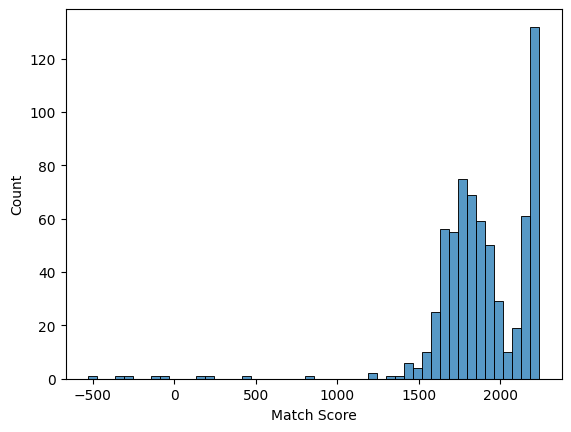

In [6]:
# Get an overall score for each protein by summing the match scores for each position

protein_match_scores['total_score'] = protein_match_scores.sum(axis=1)

# plot the distribution of match scores
sns.histplot(protein_match_scores['total_score'], bins=50)
plt.xlabel('Match Score')
plt.ylabel('Number of proteins with each match score')

The plot above is a histogram. This type of plot shows us the different **match scores** we got for our proteins, and how many proteins had these different scores. 

The plot shows us that most proteins have a very high score, meaning most of the amino acids in these sequences are ones we would expect based on the examples we've looked at. This makes sense, because most proteins found in nature should be working. 

But, sometimes mutations break a protein. In our data, a small number of proteins have really low, or even negative scores. This means there's something about the sequence that looks really unusual for this protein, and our algorithm thinks the protein is broken.

We can return to our sequence profile, and compare that to an example of a sequence with a very high score, and one with a very low score, to try to understand why this has happened. 

In [7]:
high_and_low = {'high score': protein_sequences.iloc[np.argmax(protein_match_scores['total_score'])], 'low score': protein_sequences.iloc[np.argmin(protein_match_scores['total_score'])]}
high_and_low_s = {'high score': protein_match_scores.iloc[np.argmax(protein_match_scores['total_score'])], 'low score': protein_match_scores.iloc[np.argmin(protein_match_scores['total_score'])]}

hl_df = pd.DataFrame(high_and_low)
hl_s_df = pd.DataFrame(high_and_low_s)

hl_df.transpose().style.background_gradient(cmap='RdBu', axis=None, gmap=hl_s_df.transpose(), vmin=-5, vmax=5).set_tooltips(nums.round(1)).set_properties(**{'font-size': '10px'})

Look at the sequences above, and scroll to the right to see where the red scores are. 

Looking at the sequences, it looks like the protein with the lowest score has been cut short, meaning a stop codon has appeared early in the sequence. This means the the protein most likely won't work. 

When we compare them to the sequence profile, we can see most of the amino acids in both sequences are in the top 5 most common for each position. 

### Changing Our "Match" Scores to "Brokenness" Scores

At the moment, we have scores that are high if we think the protein works. The total score for a protein depends on how long it is, since we are summing across each position in the protein. We want to be able to compare scores across different proteins, which will be very different lengths, and be able to pick out the broken ones. 

To do this, we will subtract each score for a protein from the average for that protein. This gives us a **Brokenness Score**. Proteins that still function should have a score around 0, while higher scores mean we are more confident a protein is broken.

Text(0.5, 0, 'Brokenness Score')

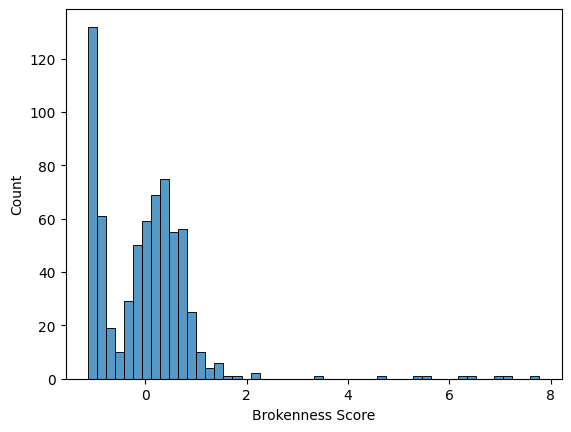

In [8]:
# convert our match scores to a brokenness score

# calculate the mean and standard deviation of the match scores
mean = np.mean(protein_match_scores['total_score'])
std = np.std(protein_match_scores['total_score'])

# calculate the scaled score of each match score
brokenness_scores = (mean - protein_match_scores['total_score']) / std

# plot the distribution of scaled scores
sns.histplot(brokenness_scores, bins=50)
plt.xlabel('Brokenness Score')

Great! Now we can see that most of our scores are around zero, and our unusual proteins have high scores - this has basically flipped the old scores horizontally and made them smaller. 

### Conclusion

In this part of the day, we created **brokenness scores** for different mutants of a protein, by comparing the mutations we see in one example to other examples we've seen from nature. If a mutation is very rare in nature, it's probably because it's damaging in some way. 

If a protein is needed for bacteria to survive, we won't see any broken variants. But, if bacteria find themselves in a new environment where they don't need that protein anymore, it tends to pick up damaging mutations, which will show up as a high **brokenness score**. 

In the next part of the day, we will use this fact to see if we can detect a change in lifestyle between different types of Salmonella by looking at these scores. 

### Reflection questions

1. Why do different parts of a protein show different patterns of amino acids?
2. Why do we not see many broken proteins in nature?